<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/yolo/Train_YOLOv5_model_on_a_Custom_Dataset_with_Weights_&_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{yolov5-pt3} -->

<a align="left" href="https://ultralytics.com/yolov5" target="_blank">
<img src="https://user-images.githubusercontent.com/26833433/125273437-35b3fc00-e30d-11eb-9079-46f313325424.png"></a>
<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{yolov5-pt3} -->

# Train YOLOv5 model on a Custom Dataset with Weights & Biases (as a part of the YOLOv5 Series)

This is a Colab for training a custom [YOLOv5](https://github.com/ultralytics/yolov5) model and using Weights & Biases to track training metrics, checkpoint weights and datasets. This Colab is featured in part 3 of the YOLOv5 Series.


### Follow along with [YOLOv5 Series →](https://www.youtube.com/playlist?list=PLD80i8An1OEHEpJVjtujEb0lQWc0GhX_4)

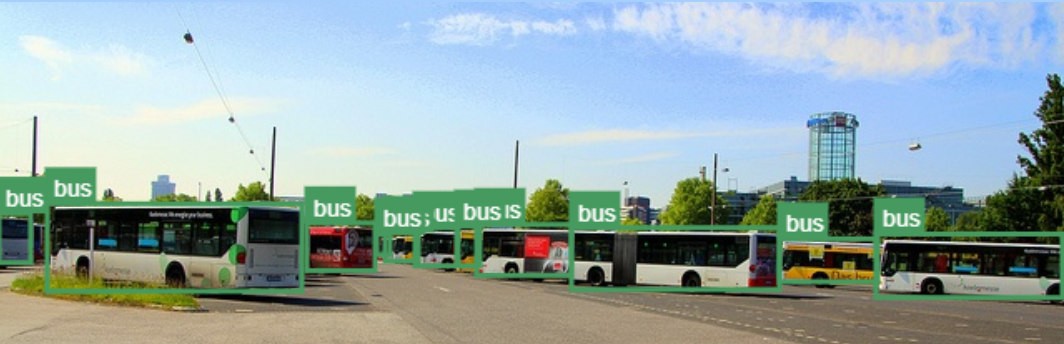

# Setup

We begin by downloading the
[YOLOv5 GitHub repo](https://github.com/ultralytics/yolov5) and installing all the requirements for YOLOv5 and `wandb`.

Here's an example of a [wandb dashboard](https://wandb.ai/ivangoncharov/custom_yolov5?workspace=user-ivangoncharov). 


In [ ]:
%%capture
!git clone https://github.com/ultralytics/yolov5.git
%cd /content/yolov5
!pip install -r requirements.txt
!pip install wandb==0.12.10

# Detect

YOLOv5 provides highly-accurate, fast models that are pretrained on the
[Common Objects in COntext (COCO) dataset](https://cocodataset.org/#home).

If your object detection application involves only
[classes from the COCO dataset](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda),
like "Stop Sign" and "Pizza",
then these pretrained models may be all you need!

The cell below runs a pretrained model on an example image
using `detect.py` from the YOLOv5 toolkit.

In [ ]:
from IPython.display import Image

!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/bus.jpg
Image(filename='runs/detect/exp/bus.jpg', width=600)

## Generating a .yaml file for training on the bus dataset that's featured in the YOLOv5 Series. You can skip this step when using your own custom dataset.

In [ ]:
import json
import yaml
data ={
'names':['closed_door', 'opened_door', 'bus' ,'number'],
'nc': 4,
'train': "wandb-artifact://wandb/custom_yolov5/train",
'val': "wandb-artifact://wandb/custom_yolov5/val",
 }
with open('bus_dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile)

# Train


Your custom classes (probably) are not among the objects in COCO,
so our pretrained models don't know how to detect them
and we can't just use `detect.py` with one of those models.

Instead, we need to train the models to detect our custom classes,
using YOLOv5's `train.py`.
We don't have to start our models from scratch though!
We can finetune the pretrained models on our custom dataset.
This substantially speeds up training.

Model training is a complex process,
so we'll want to track the inputs and outputs,
log information about model behavior during training,
and record system state and metrics.

That's where [Weights & Biases](https://wandb.ai/site)
comes in:
the `wandb` library provides all the tools you need to thoroughly
and effectively log model training experiments.

YOLOv5 comes with `wandb` already integrated,
so all you need to do is configure the logging
with command line arguments.

* `--project` sets the W&B project to which we're logging
(akin to a GitHub repo).
* `--upload_dataset` tells `wandb`
to upload the dataset as [a dataset-visualization Table](https://docs.wandb.ai/guides/datasets-and-predictions).
At regular intervals set by `--bbox_interval`,
the model's outputs on the validation set will also be logged to W&B.
* `--save_period` sets the number of epochs to wait
in between logging the model checkpoints.
If not set, only the final trained model is logged.

Even without these arguments,
basic model metrics and some model outputs will still be saved to W&B.


### To train on your custom dataset you'll need a special .yaml file. In the YOLOv5 Series we use Weights & Biases to upload our custom dataset to the cloud and generate the required .yaml file. 

#### To learn more you can watch [part 2 of the series →](https://youtu.be/a9Bre0YJ8L8)

In [ ]:
!python train.py \
  --data bus_dataset.yaml \
  --epochs 30 \
  --project custom_yolov5 \
  --bbox_interval 1 \
  --save_period 1 \
  --weights yolov5s.pt 

Here's where you can find the uploaded evaluation results in the W&B UI:

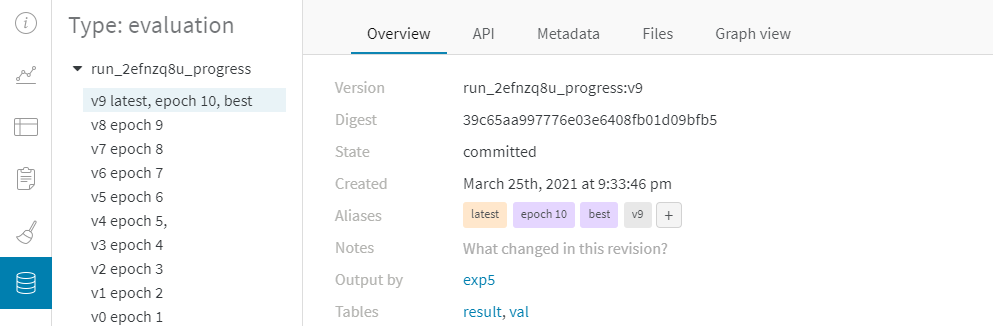


# Resume Crashed Runs

In addition to making it easier to debug our models,
the W&B integration can help rescue crash or interrupted runs.

Two steps above helped set us up for this:
1. By setting a `--save_period`, we regularly logged the model to W&B,
which means we can recreate our model and then resume the run on any
device with the dataset available.
2. By using `--upload_dataset`, we logged the data to W&B,
which means we can recreate the data as well and so
resume runs on any device, whether the dataset is present on disk or not

To resume a crashed or interrupted run:
* Go to that run's overview section on W&B dashboard
* Copy the run path
* Pass the run path as the `--resume` argument, plus the prefix
`wandb-artifact://`.
This prefix tells YOLO that the files are located on wandb, rather than locally.

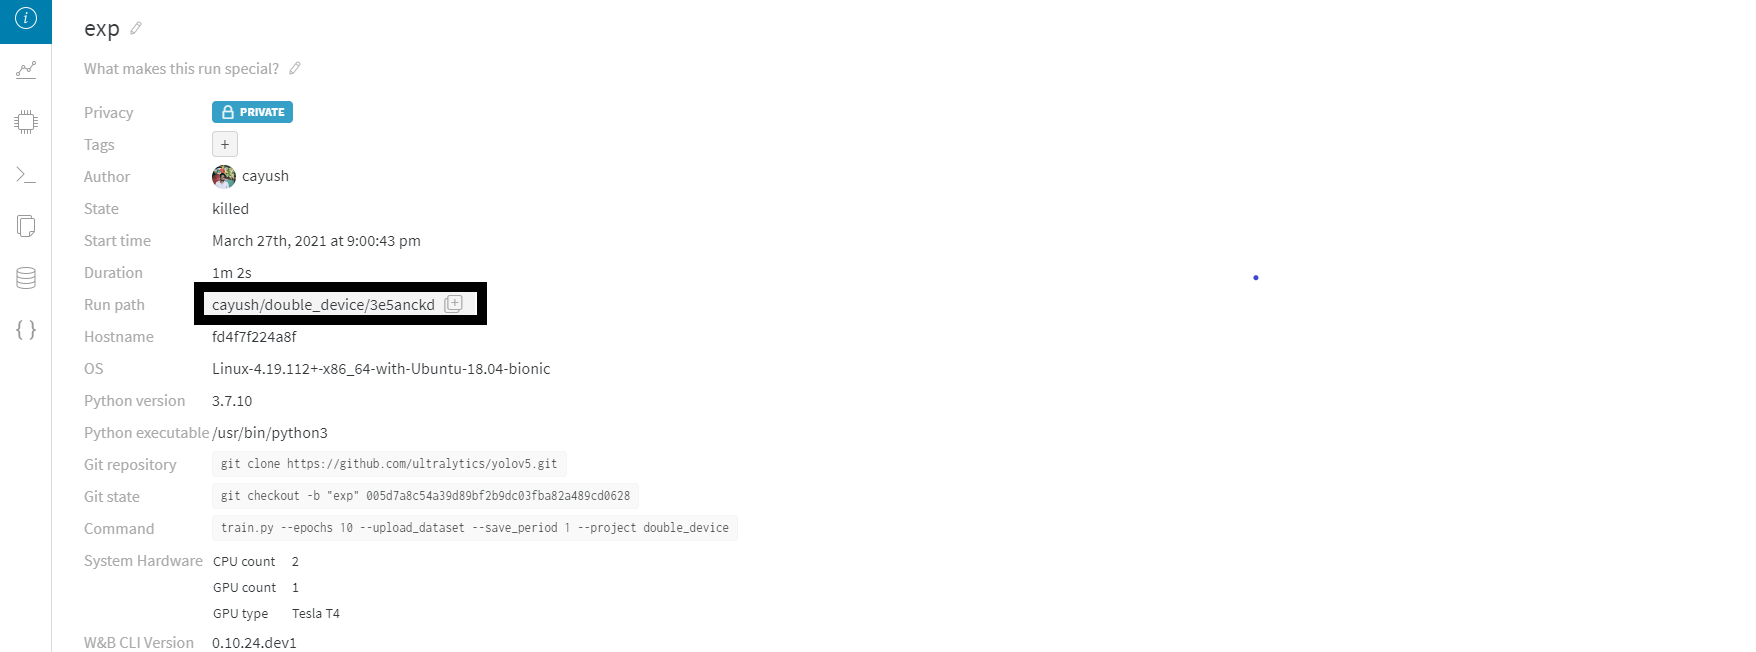


In [ ]:
crashed_run_path = "ivangoncharov/custom_yolov5/1xnnwg15"  # your path here
!python train.py --resume wandb-artifact://{crashed_run_path}

# End Notes

### Distributed Data-Parallel Training

All YOLO+W&B features are
DDP-aware and compatible.
Train on as many GPUs as you can muster,
and we'll keep logging!

### Logging Large Datasets

For very large datasets,
the initial dataset upload triggered by `--log_dataset`
might be prohibitively expensive.

In that case,
check out the
[`log_dataset.py` script](https://github.com/ultralytics/yolov5/blob/master/utils/wandb_logging/log_dataset.py)
included in YOLOv5.

### `stripped` Models

At the end of training,
a "stripped" version of the model is saved
to W&B.
This version of the model file is much smaller,
but is missing
accumulated data required for resuming training.
It's intended for use in downstream inference.